In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data_dir = 'data'

In [3]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1500 files belonging to 4 classes.


In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [5]:
batch_size = 32
image_size = (128, 128)

In [6]:
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training'
)

# Load data using flow_from_directory for validation
valid_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1202 images belonging to 4 classes.
Found 298 images belonging to 4 classes.


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 neurons for four classes
])

In [8]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 64)                3

_________________________________________________________________


In [9]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
)

Epoch 1/10
38/38 [==============================] - 41s 1s/step - loss: 1.6109 - accuracy: 0.4759 - val_loss: 0.9741 - val_accuracy: 0.6007
Epoch 2/10
38/38 [==============================] - 30s 798ms/step - loss: 0.6983 - accuracy: 0.7296 - val_loss: 0.7990 - val_accuracy: 0.6711
Epoch 3/10
38/38 [==============================] - 31s 803ms/step - loss: 0.5156 - accuracy: 0.8136 - val_loss: 0.6277 - val_accuracy: 0.8020
Epoch 4/10
38/38 [==============================] - 31s 805ms/step - loss: 0.2951 - accuracy: 0.9002 - val_loss: 0.5726 - val_accuracy: 0.8221
Epoch 5/10
38/38 [==============================] - 41s 1s/step - loss: 0.1941 - accuracy: 0.9451 - val_loss: 0.6913 - val_accuracy: 0.7819
Epoch 6/10
38/38 [==============================] - 64s 2s/step - loss: 0.0964 - accuracy: 0.9775 - val_loss: 0.4895 - val_accuracy: 0.8691
Epoch 7/10
38/38 [==============================] - 74s 2s/step - loss: 0.0436 - accuracy: 0.9925 - val_loss: 0.4952 - val_accuracy: 0.8859
Epoch 8/10


In [10]:
model.save("classifierModel.h5")

c:\Users\khize\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
from keras.models import load_model
loadedModel = load_model("classifierModel.h5")

1/1 [==============================] - 0s 28ms/step


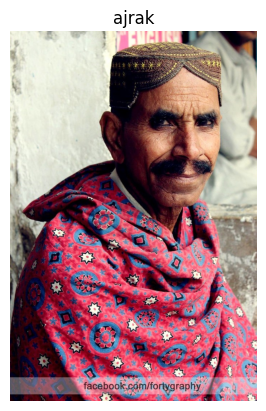

In [95]:
import matplotlib.image as mpimg
test_image_path = 'test/ajrakman.jpg'  # Change the path to your test image
test_image = tf.keras.utils.load_img(test_image_path, target_size=(128, 128))
test_image = tf.keras.utils.img_to_array(test_image)
test_image = test_image.reshape(1, 128, 128, 3)
predictions = loadedModel.predict(test_image) #model.predict()

# Display the test image and prediction result
img = mpimg.imread(test_image_path)
plt.imshow(img)
plt.axis('off')
class_labels = ['ajrak', 'balochi','kalash', 'shalwarKameez']
predicted_class = class_labels[np.argmax(predictions)]
plt.title(predicted_class)
plt.show()

In [96]:
import keras
from IPython.display import Image, display


In [97]:
model_builder = keras.applications.xception.Xception
img_size = (128, 128)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_1"
img_path = test_image_path

In [98]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

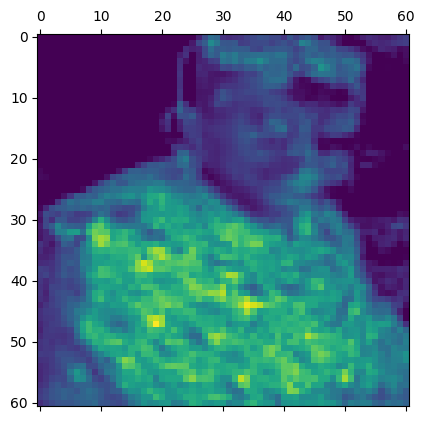

In [99]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))
model = loadedModel
model.layers[-1].activation = None
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

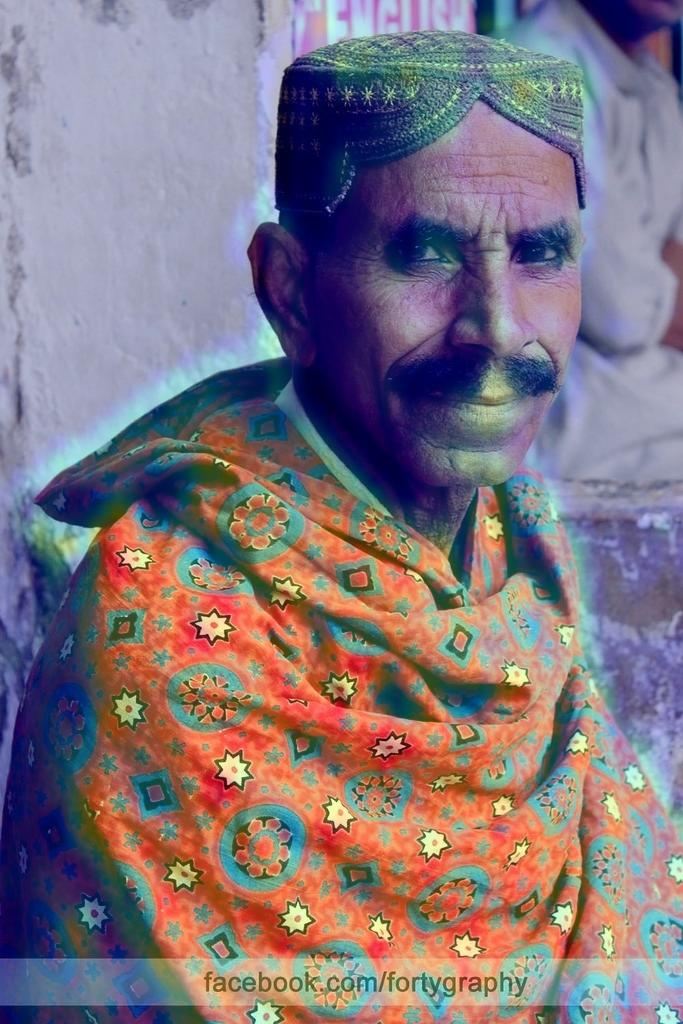

In [106]:
import matplotlib
def save_and_display_gradcam(img_path, heatmap, cam_path=f"gradCam/{test_image_path[5:]}", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = matplotlib.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)    
    display(Image(cam_path))

save_and_display_gradcam(img_path, heatmap)